In [35]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [36]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"

INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [37]:
if should_load_sisfall_data is True:
    raw_sisfall_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)

    raw_sisfall_dataset.to_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")
else:
    raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [38]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files


uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity5','Activity6','Activity13','Activity14','Activity15'])

raw_uma_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

raw_uma_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
raw_uma_df

,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
0,0.220,0.930664,0.061279,0.353027,15,14,1,0
1,0.244,0.932373,0.127197,0.355957,15,14,1,0
2,0.260,0.932373,0.127197,0.355957,15,14,1,0
3,0.280,0.935791,0.060791,0.360352,15,14,1,0
4,0.293,0.935791,0.060791,0.360352,15,14,1,0
...,...,...,...,...,...,...,...,...
93837,14.825,-0.912598,-0.041504,0.334717,9,6,2,0
93838,14.847,-0.912842,-0.037109,0.334961,9,6,2,0
93839,14.864,-0.912842,-0.037109,0.334961,9,6,2,0
93840,14.906,-0.91748,-0.038574,0.341797,9,6,2,0


In [39]:
grouped_data = []


combined_df_sorted = raw_uma_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                # 'group_id': group_id,
                'data': sensor_data,
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'data': sensor_data,
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())


if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'data': sensor_data,
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_raw_dataset = pd.DataFrame(grouped_data)
uma_raw_dataset


,subject,activity,trial,data
0,1,D1,1,acc_x acc_y acc_z 0 -0.74023...
1,1,D1,2,acc_x acc_y acc_z 0 -0.76416...
2,1,D1,3,acc_x acc_y acc_z 0 -0.75732...
3,2,D1,1,acc_x acc_y acc_z 0 -0.95336...
4,2,D1,2,acc_x acc_y acc_z 0 -0.96289...
...,...,...,...,...
314,19,D15,2,acc_x acc_y acc_z 0 -1.02294...
315,19,D15,3,acc_x acc_y acc_z 0 -1.37255...
316,19,D15,4,acc_x acc_y acc_z 0 -0.92089...
317,19,D15,5,acc_x acc_y acc_z 0 -0.90795...


In [40]:
uma_raw_dataset['data'][0]

,acc_x,acc_y,acc_z
0,-0.740234,0.571289,0.249512
1,-0.842285,0.598145,0.297119
2,-0.833252,0.425781,0.332031
3,-0.721191,0.518311,0.116455
4,-0.741699,0.651611,0.380127
...,...,...,...
280,-0.878662,0.503418,0.118896
281,-0.760742,0.463623,0.170898
282,-0.702393,0.350342,0.258301
283,-0.600098,0.412842,0.168457


In [41]:
UMA_ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02', 'D1'],  
    'jogging': ['D03', 'D04', 'D2'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11", "F12", "F13", "F14", "F15", 'D13', 'D14', 'D15'],
    'stairs': ["D5", "D6"]
}

# Create a function to map activity codes to class names
def map_activity_to_class(activity_code):
    for class_name, codes in UMA_ACTIVITY_CLASSES.items():
        if activity_code in codes:
            return class_name
    return 'unknown'

# Apply the mapping function to update the activity column
uma_raw_dataset['activity'] = uma_raw_dataset['activity'].apply(lambda x: f"D{x}" if isinstance(x, int) else x)
uma_raw_dataset['activity'] = uma_raw_dataset['activity'].apply(map_activity_to_class)

In [42]:
uma_raw_dataset['activity'].value_counts()

activity
fall       198
walking     55
stairs      38
jogging     28
Name: count, dtype: int64

In [43]:
uma_raw_dataset.drop(columns=['subject', 'trial'], inplace=True)

In [44]:
uma_raw_dataset

,activity,data
0,walking,acc_x acc_y acc_z 0 -0.74023...
1,walking,acc_x acc_y acc_z 0 -0.76416...
2,walking,acc_x acc_y acc_z 0 -0.75732...
3,walking,acc_x acc_y acc_z 0 -0.95336...
4,walking,acc_x acc_y acc_z 0 -0.96289...
...,...,...
314,fall,acc_x acc_y acc_z 0 -1.02294...
315,fall,acc_x acc_y acc_z 0 -1.37255...
316,fall,acc_x acc_y acc_z 0 -0.92089...
317,fall,acc_x acc_y acc_z 0 -0.90795...


In [45]:
import itertools
import numpy as np


def extract_features_advanced(data, with_magnitude=True):
    data = data.copy()
    # Clean and ensure all data is numeric
    for col in data.columns:
        data[col] = data[col].astype(str)
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.fillna(0)

    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")
        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0   

    # Assume data has columns: ax, ay, az (accelerometer data)
    # Extract original acceleration components
    if 'acc_x' in data.columns and 'acc_y' in data.columns and 'acc_z' in data.columns:
        ax = data['acc_x'].values
        ay = data['acc_y'].values  
        az = data['acc_z'].values
    else:
        # If columns are named differently, use first 3 columns
        ax = data.iloc[:, 0].values
        ay = data.iloc[:, 1].values
        az = data.iloc[:, 2].values

    # Add magnitude features if requested
    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:   
                slice_ = data.iloc[:, i:i+3]
                magnitude = np.linalg.norm(slice_, axis=1)
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                data[name] = magnitude

    # Calculate the new accelerometer-based features from the table
    additional_features = {}
    
    # C1: Sum vector magnitude (RMS)
    c1 = np.sqrt(np.mean(ax**2 + ay**2 + az**2))
    additional_features['C1_sum_vector_magnitude'] = c1
    
    # C2: Sum vector magnitude on horizontal plane
    c2 = np.sqrt(np.mean(ax**2 + az**2))
    additional_features['C2_horizontal_magnitude'] = c2
    
    # C3: Maximum peak-to-peak acceleration amplitude
    c3_x = np.max(ax) - np.min(ax)
    c3_y = np.max(ay) - np.min(ay) 
    c3_z = np.max(az) - np.min(az)
    c3 = np.sqrt(c3_x**2 + c3_y**2 + c3_z**2)
    additional_features['C3_max_peak_to_peak'] = c3
    
    # C4: Angle between z-axis and vertical
    c4 = np.arctan2(np.sqrt(ax**2 + az**2), -ay)
    additional_features['C4_z_axis_vertical_angle'] = np.mean(c4)
    
    # C5: Orientation of person's trunk
    rms_xz = np.sqrt(np.mean(ax**2 + az**2))
    c5 = np.arctan(rms_xz / np.mean(np.abs(ay)))
    additional_features['C5_trunk_orientation'] = c5
    
    # C6: Orientation change in horizontal plane (using moving average)
    N = min(10, len(ax)//4)  # Window size
    if N > 0:
        ax_delayed = np.roll(ax, N)
        c6 = np.mean(ax_delayed * ax)  # Simplified version
        additional_features['C6_horizontal_orientation_change'] = c6
    else:
        additional_features['C6_horizontal_orientation_change'] = 0
    
    # C7: Jerk (rate of acceleration change)
    if len(ax) > 1:
        dt = 1  # Assuming unit time steps
        jerk_x = np.diff(ax) / dt
        c7 = np.mean(np.abs(jerk_x))
        additional_features['C7_jerk'] = c7
    else:
        additional_features['C7_jerk'] = 0
    
    # C8: Standard deviation magnitude on horizontal plane
    std_x = np.std(ax)
    std_z = np.std(az)
    c8 = np.sqrt(std_x**2 + std_z**2)
    additional_features['C8_std_horizontal'] = c8
    
    # C9: Standard deviation magnitude
    std_y = np.std(ay)
    c9 = np.sqrt(std_x**2 + std_y**2 + std_z**2)
    additional_features['C9_std_magnitude'] = c9
    
    # C10: Signal magnitude area
    c10 = (np.sum(np.abs(ax)) + np.sum(np.abs(ay)) + np.sum(np.abs(az))) / len(ax)
    additional_features['C10_signal_magnitude_area'] = c10
    
    # C11: Signal magnitude area on horizontal plane
    c11 = (np.sum(np.abs(ax)) + np.sum(np.abs(az))) / len(ax)
    additional_features['C11_horizontal_signal_area'] = c11
    
    # C12: Activity signal magnitude area (integral of magnitude over time)
    magnitude_3d = np.sqrt(ax**2 + ay**2 + az**2)
    c12 = np.sum(magnitude_3d)
    additional_features['C12_activity_signal_area'] = c12
    
    # C13: Activity signal magnitude area on horizontal plane
    magnitude_horizontal = np.sqrt(ax**2 + az**2)
    c13 = np.sum(magnitude_horizontal)
    additional_features['C13_horizontal_activity_area'] = c13
    
    # C14: Velocity (approximation using integration)
    if len(ax) > 1:
        vel_x = np.cumsum(ax)
        vel_z = np.cumsum(az)
        c14 = np.sqrt(np.mean(vel_x**2) + np.mean(vel_z**2)) / len(ax)
        additional_features['C14_velocity_approx'] = c14
    else:
        additional_features['C14_velocity_approx'] = 0

    # Original statistical features
    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))

    # Create DataFrame with original features
    features_df = pd.DataFrame([features], columns=columns)
    
    # Add the new accelerometer-based features
    for feature_name, feature_value in additional_features.items():
        features_df[feature_name] = feature_value
    
    return features_df


In [46]:
import itertools
import numpy as np


def extract_features(data, with_magnitude):
    data = data.copy()
    # Clean and ensure all data is numeric
    for col in data.columns:
        data[col] = data[col].astype(str)
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.fillna(0)


    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")

        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0   


    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:   
                slice_ = data.iloc[:, i:i+3]
                magnitude = np.linalg.norm(slice_, axis=1)
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                data[name] = magnitude


    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))


    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))


    features = pd.DataFrame([features], columns=columns)
    return features


feature_list = []
labels = []
activity_codes = []

prepared_uma_dataset = uma_raw_dataset.copy()


for i in prepared_uma_dataset.index:
    data = prepared_uma_dataset['data'][i]

    features_uma = extract_features(data, True)

    feature_list.append(features_uma)
    activity_codes.append(prepared_uma_dataset['activity'][i])

# Combine into final dataset
prepared_uma_dataset = pd.concat(feature_list, ignore_index=True)

prepared_uma_dataset['class'] = activity_codes


In [47]:
SISFALL_ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02'],  
    'jogging': ['D03', 'D04'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11", "F12", "F13", "F14", "F15"],
    'stairs': ['D05','D06'],
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in SISFALL_ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name



In [48]:
def prepare_sisfall_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency):
    filtered_indices = []
    for i in raw_dataset.index:
        activity_code = raw_dataset['activity'][i]
        if activity_code in CODE_TO_CLASS:
            filtered_indices.append(i)
    
    feature_list = []
    labels = []
    subjects = []
    activity_codes = []

    for i in filtered_indices:
        data = raw_dataset['data'][i]
        activity_code = raw_dataset['activity'][i]
        data = change_activity_duration(data, duration)

        # data = change_activity_sampling(data, frequency)
        
        # Extract features (now includes the new accelerometer features)
        features = extract_features(data, with_magnitude=True)
        
        # Get class label
        class_label = CODE_TO_CLASS[activity_code]
        
        # Store results
        feature_list.append(features)
        labels.append(class_label)
        subjects.append(raw_dataset['subject'][i])
        activity_codes.append(activity_code)

    # Combine into final dataset
    prepared_dataset = pd.concat(feature_list, ignore_index=True)
    prepared_dataset['class'] = labels
    prepared_dataset['subject'] = subjects

    print(f"Final dataset shape: {prepared_dataset.shape}")
    print(f"Number of new accelerometer features added: 14")
    print("\nClass distribution:")
    print(prepared_dataset['class'].value_counts())
    
    return prepared_dataset
prepared_sisfall_dataset = prepare_sisfall_dataset(raw_sisfall_dataset, CODE_TO_CLASS, duration, frequency)


Final dataset shape: (2856, 38)
Number of new accelerometer features added: 14

Class distribution:
class
fall       1798
walking     380
jogging     370
stairs      308
Name: count, dtype: int64


In [49]:
prepared_sisfall_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking,SA01
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking,SA01
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking,SA01
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking,SA01
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking,SA01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,-0.050304,-0.831797,-0.531665,1.010431,0.017650,0.017212,0.024080,0.015056,0.132852,0.131196,...,-0.128906,-0.906250,-0.648438,0.933138,0.039062,-0.722656,-0.417969,1.034437,stairs,SE15
2852,-0.057461,-0.848906,-0.504344,1.009761,0.016946,0.017762,0.024473,0.017870,0.130176,0.133273,...,-0.148438,-0.910156,-0.597656,0.933007,0.023438,-0.773438,-0.386719,1.033670,stairs,SE15
2853,-0.040410,-0.851758,-0.500846,1.006632,0.014972,0.014511,0.019875,0.014022,0.122360,0.120462,...,-0.105469,-0.914062,-0.593750,0.941153,0.027344,-0.769531,-0.410156,1.028600,stairs,SE15
2854,-0.062992,-0.847684,-0.513423,1.010200,0.013965,0.011516,0.019549,0.010665,0.118174,0.107312,...,-0.140625,-0.910156,-0.585938,0.943958,0.015625,-0.773438,-0.441406,1.035027,stairs,SE15


In [50]:
prepared_sisfall_dataset = prepared_sisfall_dataset.drop(columns=['subject'])

In [51]:
prepared_uma_dataset 

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,walking
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,walking
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,walking
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,1.716752,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,walking
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,2.868545,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
315,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
316,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
317,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [52]:
prepared_sisfall_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,-0.050304,-0.831797,-0.531665,1.010431,0.017650,0.017212,0.024080,0.015056,0.132852,0.131196,...,0.759278,-0.128906,-0.906250,-0.648438,0.933138,0.039062,-0.722656,-0.417969,1.034437,stairs
2852,-0.057461,-0.848906,-0.504344,1.009761,0.016946,0.017762,0.024473,0.017870,0.130176,0.133273,...,0.935276,-0.148438,-0.910156,-0.597656,0.933007,0.023438,-0.773438,-0.386719,1.033670,stairs
2853,-0.040410,-0.851758,-0.500846,1.006632,0.014972,0.014511,0.019875,0.014022,0.122360,0.120462,...,0.834758,-0.105469,-0.914062,-0.593750,0.941153,0.027344,-0.769531,-0.410156,1.028600,stairs
2854,-0.062992,-0.847684,-0.513423,1.010200,0.013965,0.011516,0.019549,0.010665,0.118174,0.107312,...,0.710874,-0.140625,-0.910156,-0.585938,0.943958,0.015625,-0.773438,-0.441406,1.035027,stairs


In [53]:
final_combined_dataset = pd.concat([prepared_sisfall_dataset, prepared_uma_dataset], ignore_index=True)

final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
3171,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
3172,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
3173,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [54]:
import os
import pandas as pd
import numpy as np

earpiece_classes = ['walking', 'jogging','fall','stairs']

# read earpiece data from datasets/earpiece from *.csv files
earpiece_folder = "datasets/earpiece/"
earpiece_data = []

# Search for all CSV files in the earpiece folder
for filename in os.listdir(earpiece_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(earpiece_folder, filename)
        
        # Extract activity class from filename
        for activity in earpiece_classes:
            if activity in filename:
                class_name = activity
                break
        else:
            continue  # Skip files that don't match any activity class
        
        # Read data
        df = pd.read_csv(file_path)
        
        # Process accelerometer data
        if 'X' in df.columns and 'Y' in df.columns and 'Z' in df.columns:
            # Rename columns to match the format used in other datasets
            sensor_data = df[['X', 'Y', 'Z']].copy()
            sensor_data.columns = ['acc_y', 'acc_x', 'acc_z']
            
            # Create a record for this activity
            earpiece_data.append({
            'class': class_name,
            'data': sensor_data,
            })
        else:
            print(f"Warning: File {filename} does not contain X, Y, Z accelerometer columns")

# Convert to DataFrame
earpiece_raw_dataset = pd.DataFrame(earpiece_data)
earpiece_raw_dataset
# Extract features from the data
# feature_list = []
data_list = []
activity_labels = []

for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    features = extract_features(data, True)
    # activity_labels.append(earpiece_raw_dataset['activity'][i])

In [55]:
final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
3171,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
3172,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
3173,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [56]:
final_combined_dataset['class'].value_counts()

class
fall       1996
walking     435
jogging     398
stairs      346
Name: count, dtype: int64

In [57]:
# from sklearn.model_selection import train_test_split

# # pick only these from final_combined_dataset ['std_acc_y', 'std_mag_acc', 'centile25_mag_acc', 'centile75_mag_acc', 'C5_trunk_orientation', 'C9_std_magnitude', 'C12_activity_signal_area', 'C13_horizontal_activity_area', 'mean_acc_y', 'var_acc_y', 'centile25_acc_y', 'C3_max_peak_to_peak', 'C4_z_axis_vertical_angle']
# # Select only the most important features based on analysis
# selected_features = ['mean_acc_y', 'mean_mag_acc', 'var_acc_y', 'var_mag_acc', 'std_acc_y', 'std_mag_acc', 'min_mag_acc', 'centile25_mag_acc', 'centile75_acc_y', 'centile75_mag_acc', 'max_acc_y', 'max_mag_acc', 'ptp_acc_y', 'ptp_mag_acc', 'centile25_acc_y', 'ptp_acc_z']

# final_combined_dataset = final_combined_dataset[selected_features]
# final_combined_dataset

In [58]:
from sklearn.model_selection import train_test_split

X_train,X_test = train_test_split(final_combined_dataset, 
    test_size=0.2, 
    stratify=final_combined_dataset['class'], 
    random_state=42
)

y_train = X_train['class']
y_test = X_test['class']

final_X_train = X_train.drop(columns=['class'])
final_X_test = X_test.drop(columns=['class'])



In [59]:
final_X_train

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
246,-0.297168,-0.483223,0.207629,0.947232,0.128702,0.229470,0.233998,0.059844,0.358750,0.479030,...,1.863281,3.563466,-0.535156,-0.949219,-0.289062,0.827745,0.050781,-0.136719,0.621094,1.024561
42,-0.294642,-0.506538,-0.272134,1.071724,0.303901,0.441352,0.068392,0.082504,0.551272,0.664343,...,2.781250,3.940004,-0.886719,-1.000000,-0.398438,0.958598,0.121094,0.277344,-0.101562,1.075605
1563,0.393535,-0.152983,-0.450037,0.980269,0.248884,0.336576,0.031973,0.037314,0.498883,0.580152,...,1.406250,3.600053,-0.062500,-0.847656,-0.500000,0.964757,0.867188,0.273438,-0.335938,0.987870
3130,-0.273537,0.349409,0.896340,1.113034,0.136861,0.068832,0.161466,0.128649,0.369948,0.262359,...,5.234619,4.351171,-0.194336,0.349487,0.936157,1.036743,-0.188721,0.401123,1.005127,1.097737
1036,-0.853294,-0.032091,-0.271631,1.056055,0.198155,0.073053,0.099437,0.058317,0.445146,0.270283,...,2.906250,4.410355,-1.023438,0.046875,-0.226562,1.037225,-1.000000,0.078125,-0.203125,1.055136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,-0.699977,-0.185044,-0.050703,1.015314,0.204294,0.114245,0.219534,0.033990,0.451989,0.338002,...,2.945312,2.877901,-0.960938,-0.132812,-0.175781,0.973158,-0.236328,-0.093750,0.183594,1.051273
960,0.007168,-0.865898,-0.594785,1.560139,0.226928,1.851998,0.369357,1.117851,0.476369,1.360881,...,3.851562,4.609713,-0.339844,-2.251953,-0.587891,0.669598,0.402344,0.186523,-0.285156,2.562774
338,0.139644,-1.007074,-0.158893,1.044396,0.016535,0.030439,0.016104,0.031260,0.128589,0.174468,...,0.734375,1.137805,0.054688,-1.097656,-0.238281,0.936197,0.222656,-0.894531,-0.066406,1.123775
3061,-0.969817,-0.356107,0.170212,1.066702,0.056767,0.023315,0.014198,0.052756,0.238258,0.152692,...,0.816162,1.588687,-1.112976,-0.439819,0.105530,0.903646,-0.803955,-0.261902,0.224792,1.206663


In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(final_X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(final_X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(final_X_train, y_train)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(final_X_train, y_train)


mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(final_X_train, y_train)

lda = LinearDiscriminantAnalysis()
lda.fit(final_X_train, y_train)


if should_save_models:
    joblib.dump(svm, f"{models_output_folder}/svm_model_combined_adl.pkl")
    joblib.dump(rf, f"{models_output_folder}/rf_model_combined_adl.pkl")
    joblib.dump(knn, f"{models_output_folder}/knn_model_combined_adl.pkl")
    joblib.dump(dt, f"{models_output_folder}/dt_model_combined_adl.pkl")
    joblib.dump(lr, f"{models_output_folder}/lr_model_combined_adl.pkl")
    joblib.dump(lda, f"{models_output_folder}/lda_model_combined_adl_idle.pkl")


Model: SVC
Classification Report:
              precision    recall  f1-score   support

        fall       0.98      1.00      0.99       399
     jogging       0.99      0.96      0.97        80
      stairs       1.00      0.77      0.87        69
     walking       0.87      0.97      0.91        87

    accuracy                           0.97       635
   macro avg       0.96      0.92      0.94       635
weighted avg       0.97      0.97      0.96       635

Confusion Matrix:
Accuracy: 0.9654



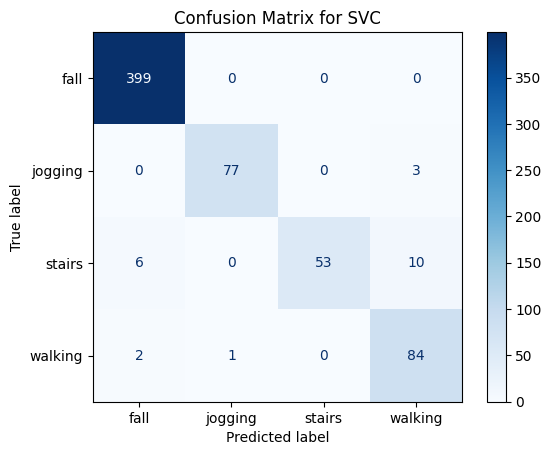

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.99      0.99       399
     jogging       0.97      0.96      0.97        80
      stairs       0.95      0.86      0.90        69
     walking       0.90      0.98      0.94        87

    accuracy                           0.97       635
   macro avg       0.96      0.95      0.95       635
weighted avg       0.97      0.97      0.97       635

Confusion Matrix:
Accuracy: 0.9717



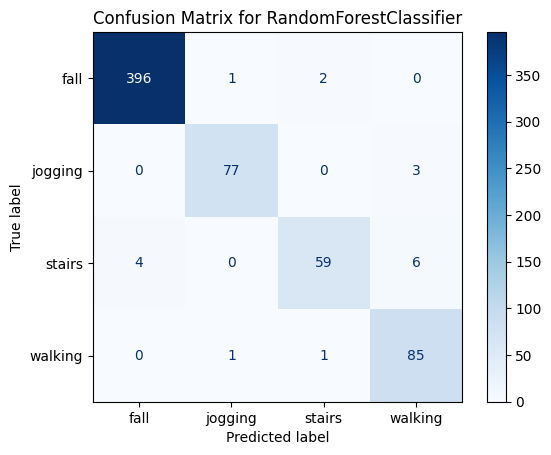

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      1.00      0.99       399
     jogging       0.99      0.95      0.97        80
      stairs       0.91      0.88      0.90        69
     walking       0.91      0.90      0.90        87

    accuracy                           0.97       635
   macro avg       0.95      0.93      0.94       635
weighted avg       0.97      0.97      0.97       635

Confusion Matrix:
Accuracy: 0.9669



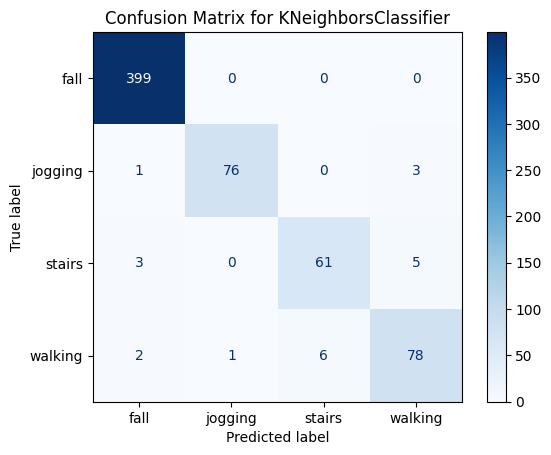

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.98      0.99       399
     jogging       0.97      0.96      0.97        80
      stairs       0.87      0.86      0.86        69
     walking       0.88      0.92      0.90        87

    accuracy                           0.96       635
   macro avg       0.93      0.93      0.93       635
weighted avg       0.96      0.96      0.96       635

Confusion Matrix:
Accuracy: 0.9591



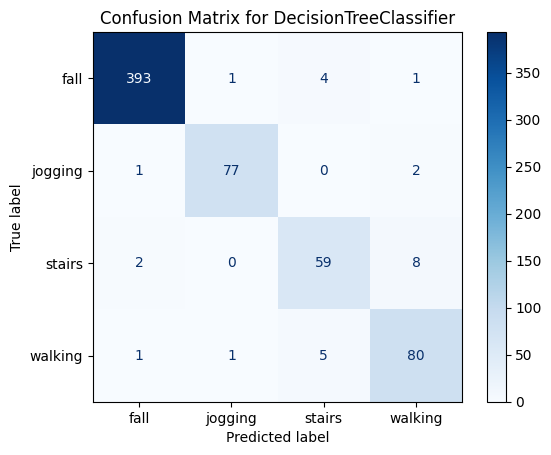

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      1.00      0.99       399
     jogging       0.99      0.95      0.97        80
      stairs       0.95      0.88      0.92        69
     walking       0.92      0.97      0.94        87

    accuracy                           0.97       635
   macro avg       0.96      0.95      0.96       635
weighted avg       0.97      0.97      0.97       635

Confusion Matrix:
Accuracy: 0.9748



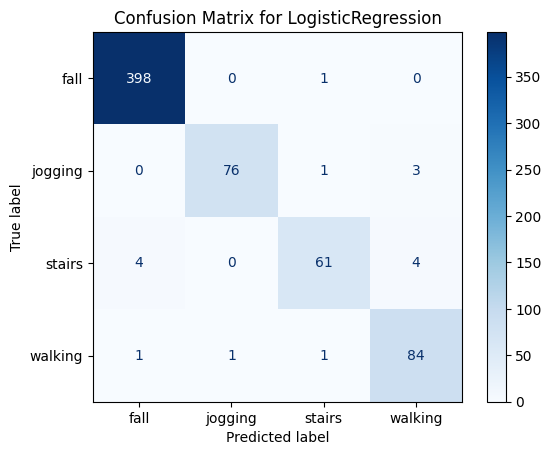

Model: MLPClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      1.00      0.99       399
     jogging       0.97      0.97      0.97        80
      stairs       0.98      0.88      0.93        69
     walking       0.89      0.94      0.92        87

    accuracy                           0.97       635
   macro avg       0.96      0.95      0.95       635
weighted avg       0.98      0.97      0.97       635

Confusion Matrix:
Accuracy: 0.9748



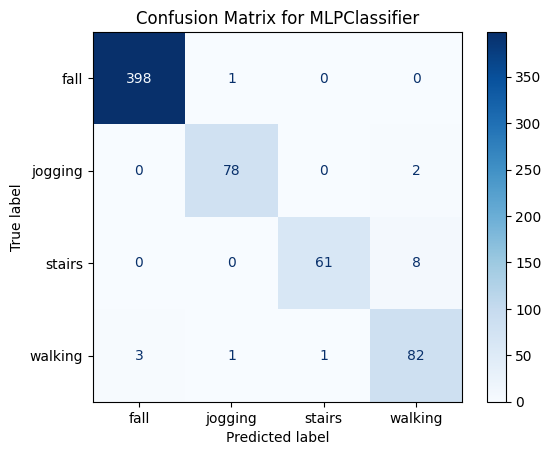

Model: LinearDiscriminantAnalysis
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      0.99      0.99       399
     jogging       0.97      0.94      0.96        80
      stairs       0.86      0.71      0.78        69
     walking       0.78      0.91      0.84        87

    accuracy                           0.94       635
   macro avg       0.90      0.89      0.89       635
weighted avg       0.95      0.94      0.94       635

Confusion Matrix:
Accuracy: 0.9433



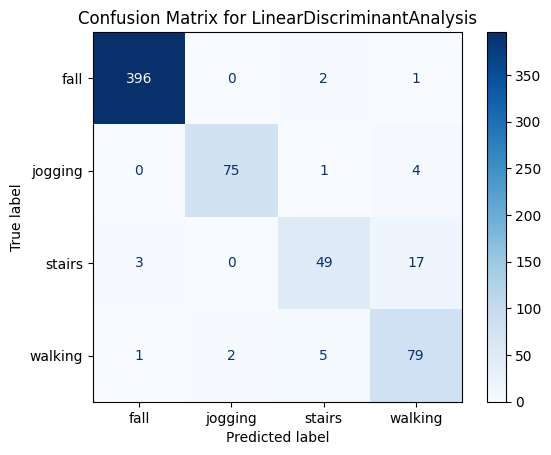

In [69]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix with default blue color scheme
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, final_X_test, y_test)
evaluate_model(rf, final_X_test, y_test)
evaluate_model(knn, final_X_test, y_test)
evaluate_model(dt, final_X_test, y_test)
evaluate_model(lr, final_X_test, y_test)
evaluate_model(mlp, final_X_test, y_test)
evaluate_model(lda, final_X_test, y_test)

In [70]:
# First, let's properly prepare the earpiece dataset
feature_list = []
class_labels = []

for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    features = extract_features(data, True)
    feature_list.append(features)
    class_labels.append(earpiece_raw_dataset['class'][i])

prepared_earpiece_dataset = pd.concat(feature_list, ignore_index=True)


# Check the column order to match the training dataset
required_columns = final_X_train.columns

# If we're missing any columns, add them with zeros
for col in required_columns:
    if col not in prepared_earpiece_dataset.columns:
        prepared_earpiece_dataset[col] = 0

# Reorder columns to match training data
prepared_earpiece_dataset = prepared_earpiece_dataset[required_columns]

print(f"Prepared earpiece dataset shape: {prepared_earpiece_dataset.shape}")
print(f"Training data shape: {final_X_train.shape}")
prepared_earpiece_dataset


Prepared earpiece dataset shape: (22, 36)
Training data shape: (2540, 36)


,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,0.546556,-0.814437,-0.133941,1.012872,0.018413,0.012891,0.026289,0.011655,0.135695,0.113540,...,1.161133,1.217528,0.452148,-0.884277,-0.250977,0.951735,0.639648,-0.744629,-0.023926,1.053523
1,0.043799,-0.668046,0.417352,1.029199,0.154383,0.075428,0.312981,0.105928,0.392916,0.274641,...,7.754883,5.773107,-0.168945,-0.886108,-0.073730,0.969459,0.363037,-0.480957,0.872070,1.033429
2,0.130228,-0.981495,0.081754,1.019077,0.034700,0.116514,0.026035,0.125707,0.186278,0.341342,...,1.472168,2.738534,0.010742,-1.203979,-0.026367,0.755763,0.225586,-0.727661,0.197266,1.250041
3,0.596157,-0.583608,-0.490585,1.010749,0.046796,0.070467,0.043037,0.075362,0.216323,0.265456,...,1.699219,2.114208,0.434570,-0.762207,-0.623047,0.759017,0.743164,-0.403320,-0.348633,1.208641
4,0.126547,-0.892698,0.332406,1.020349,0.074712,0.039711,0.050111,0.046841,0.273336,0.199277,...,1.550293,2.297987,-0.049316,-0.980469,0.189453,0.879827,0.306152,-0.765137,0.476074,1.119072
5,0.097580,-0.976068,-0.052473,1.021467,0.047016,0.114432,0.035501,0.118538,0.216832,0.338278,...,1.557617,2.693815,-0.039062,-1.182739,-0.165161,0.752464,0.235962,-0.713379,0.071289,1.226112
6,-0.277906,-0.769974,0.275957,1.009205,0.185446,0.047610,0.129292,0.090098,0.430635,0.218196,...,8.967773,10.295414,-0.505371,-0.779297,0.055908,0.984386,0.008301,-0.726685,0.454102,1.019104
7,0.421064,-0.721807,0.240276,1.019456,0.054175,0.090045,0.288914,0.149877,0.232756,0.300076,...,11.487305,12.758673,0.336426,-0.785156,-0.260132,0.975321,0.497681,-0.682617,0.630371,1.025999
8,0.372957,-0.912954,-0.074060,1.015826,0.031527,0.038684,0.027877,0.044252,0.177557,0.196684,...,0.941406,1.195542,0.257935,-1.029175,-0.181396,0.854349,0.476074,-0.766602,0.043335,1.121241
9,0.530408,-0.632372,-0.497541,1.014100,0.052813,0.080119,0.061828,0.095134,0.229812,0.283052,...,1.795410,1.702119,0.355347,-0.825806,-0.646240,0.721878,0.689575,-0.411133,-0.345703,1.240125


Random Forest Accuracy: 0.4545
              precision    recall  f1-score   support

        fall       0.67      1.00      0.80         4
     jogging       1.00      1.00      1.00         3
      stairs       0.25      0.12      0.17         8
     walking       0.22      0.29      0.25         7

    accuracy                           0.45        22
   macro avg       0.53      0.60      0.55        22
weighted avg       0.42      0.45      0.42        22


Decision Tree Accuracy: 0.3636
              precision    recall  f1-score   support

        fall       0.80      1.00      0.89         4
     jogging       0.00      0.00      0.00         3
      stairs       0.00      0.00      0.00         8
     walking       0.33      0.57      0.42         7

    accuracy                           0.36        22
   macro avg       0.28      0.39      0.33        22
weighted avg       0.25      0.36      0.30        22


Logistic Regression Accuracy: 0.5455
              precision    re

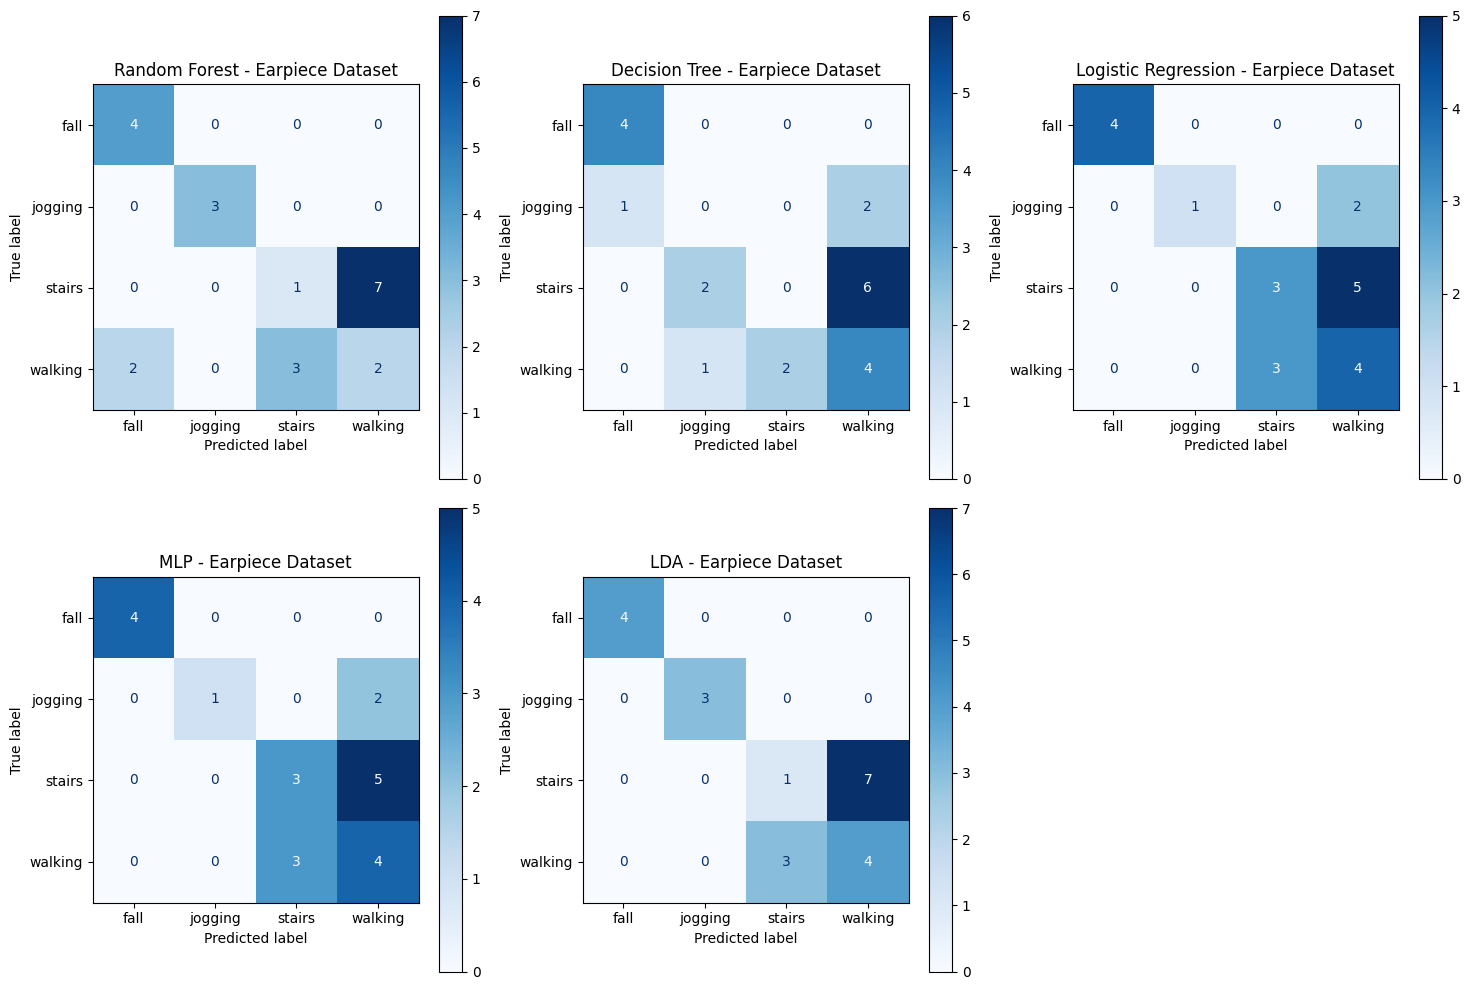

In [73]:
# Make predictions using the trained models
rf_pred = rf.predict(prepared_earpiece_dataset)
dt_pred = dt.predict(prepared_earpiece_dataset)
lr_pred = lr.predict(prepared_earpiece_dataset)
mlp_pred = lr.predict(prepared_earpiece_dataset)
lda_pred = lda.predict(prepared_earpiece_dataset)



print(f"Random Forest Accuracy: {accuracy_score(class_labels, rf_pred):.4f}")
print(classification_report(class_labels, rf_pred))
print()


print(f"Decision Tree Accuracy: {accuracy_score(class_labels, dt_pred):.4f}")
print(classification_report(class_labels, dt_pred))
print()

print(f"Logistic Regression Accuracy: {accuracy_score(class_labels, lr_pred):.4f}")
print(classification_report(class_labels, lr_pred))
print()

print(f"MLP Accuracy: {accuracy_score(class_labels, mlp_pred):.4f}")
print(classification_report(class_labels, mlp_pred))
print()

print(f"LDA Accuracy: {accuracy_score(class_labels, lda_pred):.4f}")
print(classification_report(class_labels, lda_pred))
print()

unique_labels = np.unique(np.concatenate([np.unique(class_labels), np.unique(y_train)]))

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
cm = confusion_matrix(class_labels, rf_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Random Forest - Earpiece Dataset")


plt.subplot(2, 3, 2)
cm = confusion_matrix(class_labels, dt_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Decision Tree - Earpiece Dataset")

plt.subplot(2, 3, 3)
cm = confusion_matrix(class_labels, lr_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Logistic Regression - Earpiece Dataset")

plt.subplot(2, 3, 4)
cm = confusion_matrix(class_labels, mlp_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("MLP - Earpiece Dataset")

plt.subplot(2, 3, 5)
cm = confusion_matrix(class_labels, lda_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("LDA - Earpiece Dataset")




plt.tight_layout()
plt.show()